In [6]:
using Plots
using QuadGK
using LinearAlgebra

In [7]:
aomega(omega) = exp(-0.5 * omega^2)/sqrt(2*π)

aomega (generic function with 1 method)

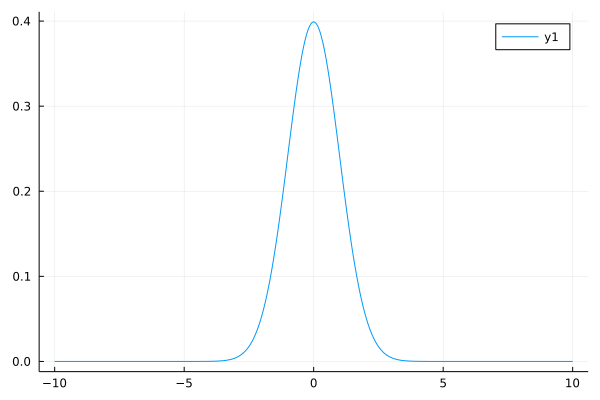

In [8]:
wmax = 10
omegas = LinRange(-wmax, wmax, 1000)
plot(omegas, aomega.(omegas))

In [9]:
quadgk(x -> aomega(x), 0, wmax)

(0.5000000000000001, 5.214338213455259e-10)

In [10]:
nmom = 10
Tp = Float64[]
for mom in 0:(nmom-1)
    push!(Tp, quadgk(x -> (x^mom) * aomega(x), 0, wmax)[1])
end
Tp

10-element Vector{Float64}:
   0.5000000000000001
   0.39894228040143276
   0.5000000000000001
   0.7978845608028649
   1.5000000000000004
   3.191538243211462
   7.500000000000002
  19.149229459268764
  52.5
 153.19383567415017

$$
T^{(n)}_p = (-1)^{n+1} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
S_n = T[0]^{-1/2} T[n] T[0]^{-1/2}
$$

In [11]:
function reconst(T)
    nmom = length(T)
    S = (1/sqrt(T[1])) * T * (1/sqrt(T[1]))
    println(S)

    As = Dict{Int,ComplexF64}()
    Bs = Dict{Int,ComplexF64}()
    Cs = Dict{Tuple{Int,Int},ComplexF64}()

    # Initial values
    As[0] = S[2]
    Bs[0] = 0.0
    Cs[0,0] = 1.0

    function get_S(i)
        i <= nmom-1 ? S[i+1] : 0.0
    end
    
    function get_Cs(n, j)::ComplexF64
        if j < 0 || j > n || n < 0
            return 0.0
        end
        return Cs[(n, j)]
    end

    for n in 0:nmom
        #println("n = $n")
        # Update B[n+1]
        bfirst = sum(conj(Cs[n,l]) * get_S(j+l+1) * get_Cs(n, j-1) for j in 0:(n+1), l in 0:n)
        Bs[n+1] = sqrt(bfirst  - As[n]^2  - conj(Bs[n]^2))

        # C(n+1, j) for j = 0, ..., n+1 (otherwise 0)
        for j in 0:(n+1)
            Cs[(n+1, j)] = (get_Cs(n, j-1) - get_Cs(n, j) * As[n] - get_Cs(n-1, j) * conj(Bs[n])) / Bs[n+1]
        end

        # Update A[n+1]
        As[n+1] = sum(conj(get_Cs(n+1, l) * get_S(j+l+1) * get_Cs(n+1, j)) for j in 0:(n+1), l in 0:(n+1))

        if length(As) >= (nmom + 1) ÷ 2
            break
        end
    end
    return  As, Bs
end

As, Bs = reconst(Tp)

[1.0, 0.7978845608028654, 1.0, 1.5957691216057293, 3.0, 6.383076486422923, 15.000000000000002, 38.29845891853752, 104.99999999999997, 306.3876713483003]


(Dict{Int64, ComplexF64}(0 => 0.7978845608028654 + 0.0im, 4 => 2.4468613798345586 + 0.0im, 2 => 1.8186328480770477 + 0.0im, 3 => 2.156280896530518 + 0.0im, 1 => 1.3978445959578956 + 0.0im), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 4 => 1.1578118971928315 + 0.0im, 2 => 0.8262265173176773 + 0.0im, 3 => 1.00494990222208 + 0.0im, 1 => 0.6028102749890869 + 0.0im))

In [12]:
nc = length(As)
htri = zeros(ComplexF64, nc, nc)
for i in 1:nc
    htri[i, i] = As[i-1]
end
for i in 1:(nc-1)
    htri[i, i+1] = Bs[i]
    htri[i+1, i] = conj(Bs[i])
end

htri

5×5 Matrix{ComplexF64}:
 0.797885+0.0im   0.60281+0.0im       0.0+0.0im      0.0+0.0im      0.0+0.0im
  0.60281-0.0im   1.39784+0.0im  0.826227+0.0im      0.0+0.0im      0.0+0.0im
      0.0+0.0im  0.826227-0.0im   1.81863+0.0im  1.00495+0.0im      0.0+0.0im
      0.0+0.0im       0.0+0.0im   1.00495-0.0im  2.15628+0.0im  1.15781+0.0im
      0.0+0.0im       0.0+0.0im       0.0+0.0im  1.15781-0.0im  2.44686+0.0im

In [13]:
e = eigen(Hermitian(htri))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
5-element Vector{Float64}:
 0.14176381083448594
 0.6828020588843227
 1.500409626597114
 2.5169174810237207
 3.7756113038632337
vectors:
5×5 Matrix{ComplexF64}:
  -0.52943-0.0im   0.665356+0.0im  …  -0.193687-0.0im  0.0305082-0.0im
  0.576251+0.0im  -0.127023-0.0im     -0.552338-0.0im   0.150702-0.0im
 -0.489783-0.0im   -0.37551-0.0im     -0.606795-0.0im   0.411442+0.0im
  0.343488+0.0im   0.528848+0.0im     0.0324803-0.0im   0.677317-0.0im
 -0.172529-0.0im  -0.347101-0.0im      0.536799+0.0im   0.590183-0.0im

In [14]:
weight = real.(conj.(e.vectors[1, :]) .* e.vectors[1, :])

5-element Vector{Float64}:
 0.2802963269265304
 0.4426982022148655
 0.23855988461259006
 0.03751483891614634
 0.0009307473298674158

In [15]:
sum(weight)

0.9999999999999998

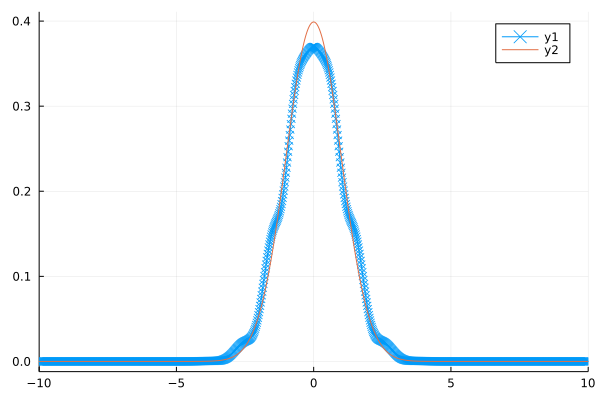

In [16]:
δ = 0.35
gaussian(x, μ) = exp(-0.5 * ((x-μ)/δ)^2)/(sqrt(2π) * δ)
aomega_reconst = zeros(Float64, length(omegas))
for ie in eachindex(e.values)
    aomega_reconst .+= gaussian.(omegas, e.values[ie]) * weight[ie]
end
p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, 0.5 * (aomega_reconst + reverse(aomega_reconst)), xlim=(-wmax, wmax), marker=:x)
plot!(p, omegas, aomega.(omegas))

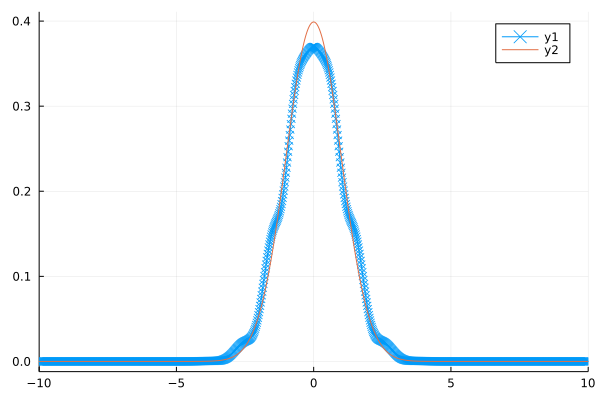

In [18]:
#δ = 0.35
#gaussian(x, μ) = exp(-0.5 * ((x-μ)/δ)^2)/(sqrt(2π) * δ)
##aomega_reconst = zeros(Float64, length(omegas))
#for ie in eachindex(e.values)
#    aomega_reconst .+= 0.5 * gaussian.(omegas, e.values[ie]) * weight[ie]
#end
#p = plot(xlim=(-wmax, wmax))
#plot!(p, omegas,  (aomega_reconst + reverse(aomega_reconst)), xlim=(-wmax, wmax), marker=:x)
#plot!(p, omegas, aomega.(omegas))

In [ ]:
from fractions import fractions